In [4]:
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr

from salishsea_tools import viz_tools

%matplotlib inline

In [5]:
bathydata = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
bathy = bathydata['Bathymetry']
meshdata = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
gdept_1d = meshdata['gdept_1d']
e3t_1d = meshdata['e3t_1d']
e3t_0 = meshdata['e3t_0'][0]
umask = meshdata['umask'][0]
vmask = meshdata['vmask'][0]
tmask = meshdata['tmask'][0]
realdepthdata = xr.open_dataset('/home/sallen/MEOPAR/grid/AfterNEMOBathy201702.nc')
realdepth = realdepthdata['Bathymetry']
print (realdepth.shape, e3t_0.shape)

g = 9.8

(898, 398) (40, 898, 398)


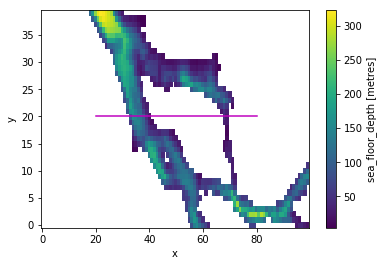

In [6]:
bathy[850:890, 30:130].plot()
plt.plot([50-30, 110-30], [870-850, 870-850], 'm-')

So along 870, from 50 to 110

In [7]:
iii = 870
jmin = 50
jmax = 110

121.86651840226745


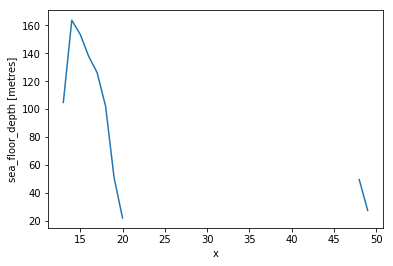

In [8]:
bathy[iii, jmin:jmax].plot()
print (gdept_1d.values[0, 27])

In [9]:
area = (e3t_0[:, iii, jmin:jmax] * 440 * tmask[:, iii, jmin:jmax]).sum()
area

<xarray.DataArray ()>
array(411545.855272)

In [10]:
kmax = 31

201812 2016 results are split across results/results2  
so use 201806 results in nowcast-green
NOPE no e3t so 2017 in results2

In [24]:
def find_flux(directories):
    icount = 0.
    flux = np.zeros((kmax, jmax-jmin))
    for directory in glob.glob(directories):
        vfile = directory + '/SKOG_1d_*_grid_V*.nc'
        for vel in glob.glob(vfile):
            eee = vel.replace('grid_V', 'carp_T')
            print (icount)
            ds = nc.Dataset(vel)
            vdata = ds['vomecrty']
            vvel = np.array(vdata[0, :kmax, iii, jmin:jmax])
            ds.close()
            de = nc.Dataset(eee)
            edata = de['e3t']
            e3t = np.array(edata[0, :kmax, iii, jmin:jmax])
            e3tu = np.array(edata[0, :kmax, iii+1, jmin:jmax])
            de.close()
            for jj in range(jmax-jmin):
                for kk in range(kmax):
                    e3v = min(e3t[kk, jj], e3tu[kk, jj])
                    flux[kk, jj] = flux[kk, jj] + (vvel[kk, jj]*e3v)
            icount = icount +1
    return flux, icount

In [25]:
flux, icount = find_flux('/data/sallen/results/MEOPAR/SKOG/BR_2016_lessSSH_*')

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
144.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
152.0
153.0
154.0
155.0
156.0
157.0
158.0
159.0
160.0
161.0
162.0
163.0
164.0
165.0
166.0
167.0
168.0
169.0
170.0
171.0
172.0
173.0
174.0
175.0
176.0
177.0
178.0
179.0
180.0
181.0
182.0
183.0
184.0


In [26]:
print (flux.shape, kmax)

(31, 60) 31


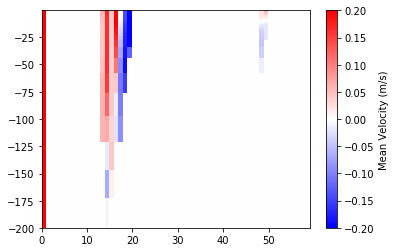

In [27]:
flux_forplot = np.empty_like(flux)
for j in range(jmax-jmin):
    flux_forplot[:kmax, j] = flux[:kmax, j]/(366)/e3t_1d[0, :kmax]
plt.pcolormesh(np.arange(60), -gdept_1d[0,:kmax], flux_forplot, cmap='bwr', vmax=0.2, vmin=-0.2 )
cb = plt.colorbar()
cb.set_label('Mean Velocity (m/s)')

1418.585345298406
<xarray.DataArray ()>
array(0.003447)
<xarray.DataArray ()>
array(26.803622)  km in 90 days


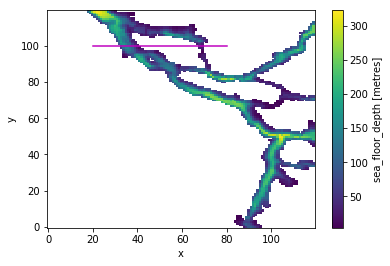

In [30]:
print (flux[:, 1:].sum()/366*440)
print (flux[:, 1:].sum()/366*440/area)
print (flux[:, 1:].sum()/366*440/area * 86400 * 90/ 1000, ' km in 90 days')
bathy[890-120:890, 30:150].plot()
plt.plot([50-30, 110-30], [870-890+120, 870-890+120], 'm-')

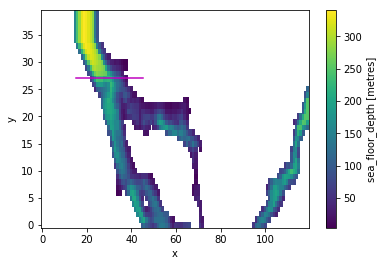

In [43]:
bathy[898-40:898, 30:150].plot()
plt.plot([45-30, 75-30], [885-898+40, 885-898+40], 'm-')

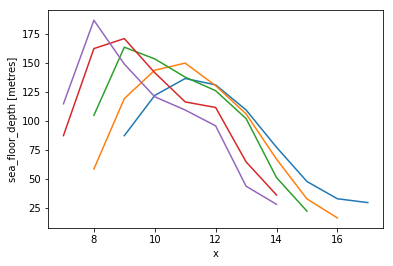

In [50]:
bathy[868, 55:85].plot()
bathy[869, 55:85].plot()
bathy[870, 55:85].plot()
bathy[871, 55:85].plot()
bathy[872, 55:85].plot()



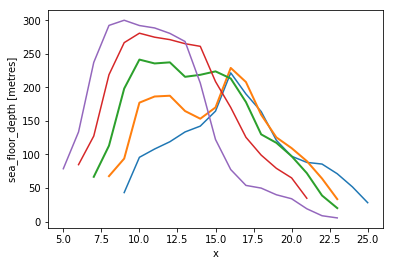

In [52]:
bathy[883, 45:75].plot()
bathy[884, 45:75].plot(linewidth=2) #884 45:75 
bathy[885, 45:75].plot(linewidth=2)
bathy[886, 45:75].plot()
bathy[887, 45:75].plot()

In [36]:
#0.98 gives 3050 m3/s 
#0.62 given 1420 m3/s
print (3050-1420, 3050-(3050-1420)*0.48/0.36, 0.5)
print (0.25*(3530+3050+3270+2360))

1630 876.6666666666665 0.5
3052.5


3300 m3/s south

In [ ]:
bern = np.zeros((897, 397))

for directory in glob.glob('/results2/SalishSea/hindcast.201812_annex/??jan17'):
    uvile = directory + '/SalishSea_1h_*_grid_U.nc'
    vfile = directory + '/SalishSea_1h_*_grid_V.nc'
    efile = directory + '/SalishSea_1h_*_carp_T.nc'
    uel = glob.glob(uvile)[0]
    vel = glob.glob(vfile)[0]
    eee = glob.glob(efile)[0]
    print (vfile)
    with xr.open_dataset(uel)['vozocrtx'] as udata:
        with xr.open_dataset(vel)['vomecrty'] as vdata:
            with xr.open_dataset(eee)['e3t'] as edata:
                for tt in range(24):
                    uvel = np.array(np.array(udata[tt]) * umask)
                    vvel = np.array(np.array(vdata[tt]) * vmask)
                    e3t = np.array(edata[tt])
                    uu, vv = viz_tools.unstagger(uvel, vvel)
                    vuu = (uu* e3t[:, :-1, :-1]).sum(axis=0)/(
                        realdepth[:-1, :-1]+(1-tmask[0, :-1, :-1]))*tmask[0, :-1, :-1]
                    uvv = (vv * e3t[:, :-1, :-1]).sum(axis=0)/(
                        realdepth[:-1, :-1]+(1-tmask[0, :-1, :-1]))*tmask[0, :-1, :-1]
                    bern = bern + (vuu**2 + uvv**2)/(2*g)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
colours = ax.pcolormesh(bern/24./9, cmap='bwr', vmax=0.2)
fig.colorbar(colours)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
colours = ax.pcolormesh(bern/24./9, cmap='bwr', vmax=0.01, vmin=-0.01)
fig.colorbar(colours)
ax.set_ylim(700, 898)
ax.set_xlim(40, 240)

In [ ]:
print (bern[895, :].max()/24/9)